In [15]:
import astropy.units as u
import astropy.constants as c
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import sys 
sys.path.append('/Users/clairewilliams/opt/anaconda3/lib/python3.9/site-packages')
sys.path.append('../../model-timescales/src')
import pandas
from timescales.data import build_bulk_energy_grid
from timescales import TimescaleEnsemble
from timescales.analysis.model import create_dynamical_model_integral
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 15

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(71,0.27,Ob0=0.044, Tcmb0=2.726 *u.K)

In [16]:
masses_array   = np.logspace(4, 9, 10) * u.Msun
radii_array    = np.logspace(-0.7, 2, 10) * u.pc
velocity_array = np.logspace(-0.7, 2.2, 10) * u.km/u.s

grid = build_bulk_energy_grid(masses_array, radii_array, velocity_array,
                              alpha=3/5, energy_unit=u.erg)


# Example: access aligned arrays
M = grid['M']   # Msun
R = grid['R']   # pc
V = grid['V']   # km/s
K = grid['K']   # erg
U = grid['U']   # erg

print(len(M), len(R), len(V), len(K), len(U))  # -> 1_000_000 each (100*100*100

145 145 145 145 145


In [17]:
model = TimescaleEnsemble(grid, 
                    densityModel="power-law",
                    Nsampling = 100,
                    timescales_kwargs={'cosmology':cosmo},
                    profile_kwargs={"alpha":1.75})

Using power-law model with properties:
alpha=1.25
Using parameters for timescale evaluation
cosmology=FlatLambdaCDM(H0=71.0 km / (Mpc s), Om0=0.27, Tcmb0=2.726 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.044)
No imf arguments given. Defaulting to 'salpeter'.


In [18]:
mass_fraction_retained = 0.1
z_final = 12
results =  create_dynamical_model_integral(model, 
                            z_final=z_final,
                            mass_fraction_retained=mass_fraction_retained)

will use defaults for  {'Mcollisions': <Quantity 1. solMass>, 'n_unit': <Quantity 1. 1 / cm3>, 'v_unit': Unit("cm / s"), 'Mstar_unit': Unit("solMass")}
Selected coulomb function based on BH or not.
will use defaults for  {'v_unit': Unit("km / s"), 'rho_unit': Unit("g / cm3"), 'mass_unit': Unit("solMass")}
Selected coulomb function based on BH or not.
will use defaults for  {'M_obj': <Quantity 10. solMass>, 'v_unit': Unit("km / s"), 'rho_unit': Unit("g / cm3"), 'mass_unit': Unit("solMass")}
Selected coulomb function based on BH or not.
will use defaults for  {'v_unit': Unit("km / s"), 'rho_unit': Unit("g / cm3"), 'mass_unit': Unit("solMass")}
Using nearest neighbor for interaction type.
collisions occur in 128 systems
mass loss occurs in 0 systems
0


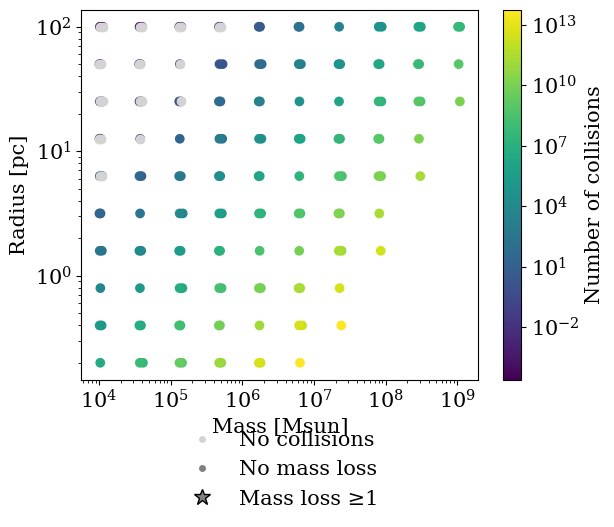

In [19]:
vratio = np.array([-results['potential'][i]/results['kinetic'][i] for i in range(len(results['potential']))])
x = np.array([results['mass'][i].value+(results['mass'][i].value *0.01 * vratio[i]) for i in range(len(vratio))]) * u.Msun
y = results['radius'] *u.pc
c = np.array(results['N_collisions'])
mflag = np.array(results['N_collisions_massloss'])  # new flag array

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

# Mask zeros for log-scaling
c_masked = np.ma.masked_equal(c, 0)
norm = mcolors.LogNorm(vmin=c_masked.min(), vmax=c_masked.max())
cmap = plt.cm.viridis

# --- Separate the two populations by shape ---
mask_star = mflag >= 1   # star markers
mask_circle = ~mask_star # circle markers

# Plot circles (no mass loss)
sc1 = ax.scatter(x[mask_circle], y[mask_circle], 
                 c=np.ma.masked_equal(c[mask_circle], 0), 
                 cmap=cmap, norm=norm, marker='o')

# Plot stars (mass loss ≥1)
sc2 = ax.scatter(x[mask_star], y[mask_star], 
                 c=np.ma.masked_equal(c[mask_star], 0), 
                 cmap=cmap, norm=norm, marker='*', s=120, edgecolor='k')

# Add explicit grey points for zeros
ax.scatter(x[c < 1], y[c < 1], color="lightgrey", marker='o', alpha=1, label="0 collisions")

# --- Colorbar ---
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cb.set_label("Number of collisions")

# Add legend for shapes
legend_handles = [
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='lightgrey',
               label='No collisions'),
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='gray',
               label='No mass loss'),
    plt.Line2D([], [], marker='*', color='w', markerfacecolor='gray',
               markeredgecolor='k', markersize=12, label='Mass loss ≥1')
]

ax.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.4),
    frameon=False
)
ax.set_xlabel("Mass [Msun]")
ax.set_ylabel("Radius [pc]")

plt.show()

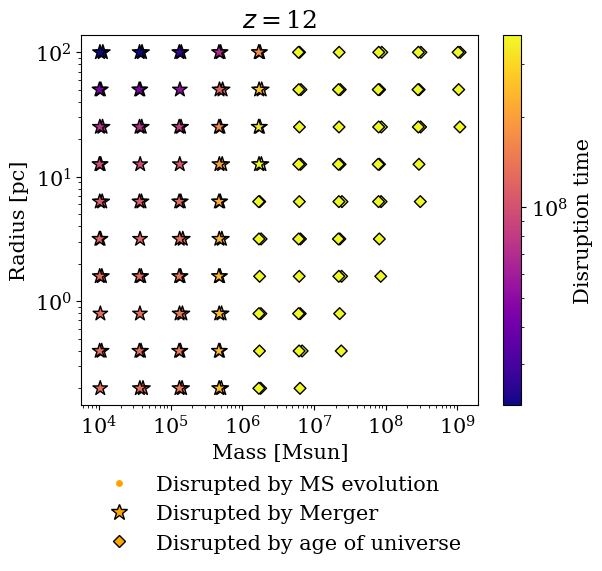

In [29]:
vratio = np.array([-results['potential'][i]/results['kinetic'][i] for i in range(len(results['potential']))])
x = np.array([results['mass'][i].value+(results['mass'][i].value *0.01 * vratio[i]) for i in range(len(vratio))]) * u.Msun
y = results['radius'] *u.pc
c = np.array(results['minimum_disruption_time']*u.yr)
mflag = np.array(results['which_disruption_time'])  # new flag array

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

# Mask zeros for log-scaling
c_masked = np.ma.masked_equal(c, 0)
norm = mcolors.LogNorm(vmin=c_masked.min(), vmax=c_masked.max())
cmap = plt.cm.plasma

# --- Separate the two populations by shape ---
mask_star = mflag == 0   # star markers
mask_circle = mflag == 1 # circle markers
mask_square= mflag == 2 # circle markers

# Plot circles (no mass loss)
sc1 = ax.scatter(x[mask_circle], y[mask_circle], 
                 c=np.ma.masked_equal(c[mask_circle], 0), 
                 cmap=cmap, norm=norm, marker='o')

# Plot stars (mass loss ≥1)
sc2 = ax.scatter(x[mask_star], y[mask_star], 
                 c=np.ma.masked_equal(c[mask_star], 0), 
                 cmap=cmap, norm=norm, marker='*', s=120, edgecolor='k')
# Plot stars (mass loss ≥1)
sc2 = ax.scatter(x[mask_square], y[mask_square], 
                 c=np.ma.masked_equal(c[mask_square], 0), 
                 cmap=cmap, norm=norm, marker='D',edgecolor='k')

# # Add explicit grey points for zeros
# ax.scatter(x[c == 0], y[c == 0], color="lightgrey", marker='o', alpha=0.7, label="0 collisions")

# --- Colorbar ---
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cb.set_label("Disruption time")

# Add legend for shapes
legend_handles = [
    # plt.Line2D([], [], marker='o', color='w', markerfacecolor='lightgrey',
    #            label='No collisions'),
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='orange',
               label='Disrupted by MS evolution'),
    plt.Line2D([], [], marker='*', color='w', markerfacecolor='orange',
               markeredgecolor='k', markersize=12, label='Disrupted by Merger'),
    plt.Line2D([], [], marker='D', color='w', markerfacecolor='orange',
               markeredgecolor='k', label='Disrupted by age of universe')
]

ax.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.45),
    frameon=False
)
ax.set_xlabel("Mass [Msun]")
ax.set_ylabel("Radius [pc]")
plt.title(r"$z= $"+str(z_final))
plt.savefig("../plots/disruption_"+str(model.Mstar)+str(model.densityModel)+str(model.alpha)+str(model.imfModel)+"z"+str(z_final)+".pdf")
plt.show()

In [30]:
model = TimescaleEnsemble(grid, 
                    densityModel="power-law",
                    Nsampling = 100,
                    timescales_kwargs={'cosmology':cosmo},
                    profile_kwargs={"alpha":1.75})

mass_fraction_retained = 0.1
z_final = 8
results =  create_dynamical_model_integral(model, 
                            z_final=z_final,
                            mass_fraction_retained=mass_fraction_retained)

Using power-law model with properties:
alpha=1.25
Using parameters for timescale evaluation
cosmology=FlatLambdaCDM(H0=71.0 km / (Mpc s), Om0=0.27, Tcmb0=2.726 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.044)
No imf arguments given. Defaulting to 'salpeter'.
will use defaults for  {'Mcollisions': <Quantity 1. solMass>, 'n_unit': <Quantity 1. 1 / cm3>, 'v_unit': Unit("cm / s"), 'Mstar_unit': Unit("solMass")}
Selected coulomb function based on BH or not.
will use defaults for  {'v_unit': Unit("km / s"), 'rho_unit': Unit("g / cm3"), 'mass_unit': Unit("solMass")}
Selected coulomb function based on BH or not.
will use defaults for  {'M_obj': <Quantity 10. solMass>, 'v_unit': Unit("km / s"), 'rho_unit': Unit("g / cm3"), 'mass_unit': Unit("solMass")}
Selected coulomb function based on BH or not.
will use defaults for  {'v_unit': Unit("km / s"), 'rho_unit': Unit("g / cm3"), 'mass_unit': Unit("solMass")}
Using nearest neighbor for interaction type.


/Users/clairewilliams/Research/Calculations/timescale-plots/models/../../model-timescales/src/timescales/physics/halo_environment.py:135: RuntimeWarning: invalid value encountered in divide
  normalization_offset = stfunction17/stfunction


collisions occur in 131 systems
mass loss occurs in 0 systems
0


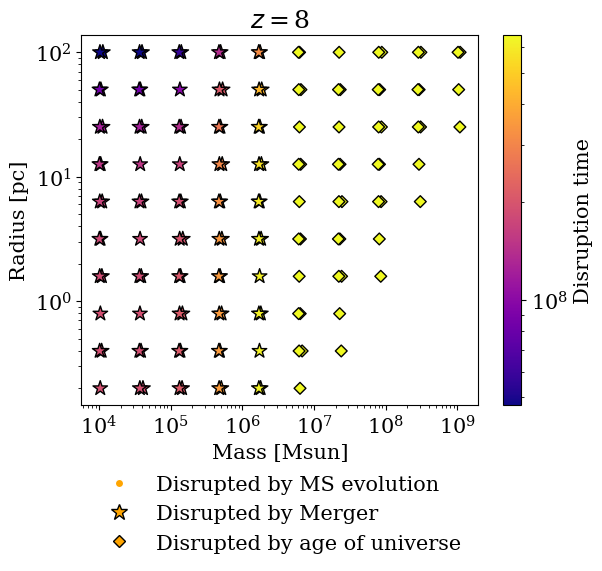

In [31]:
vratio = np.array([-results['potential'][i]/results['kinetic'][i] for i in range(len(results['potential']))])
x = np.array([results['mass'][i].value+(results['mass'][i].value *0.01 * vratio[i]) for i in range(len(vratio))]) * u.Msun
y = results['radius'] *u.pc
c = np.array(results['minimum_disruption_time']*u.yr)
mflag = np.array(results['which_disruption_time'])  # new flag array

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

# Mask zeros for log-scaling
c_masked = np.ma.masked_equal(c, 0)
norm = mcolors.LogNorm(vmin=c_masked.min(), vmax=c_masked.max())
cmap = plt.cm.plasma

# --- Separate the two populations by shape ---
mask_star = mflag == 0   # star markers
mask_circle = mflag == 1 # circle markers
mask_square= mflag == 2 # circle markers

# Plot circles (no mass loss)
sc1 = ax.scatter(x[mask_circle], y[mask_circle], 
                 c=np.ma.masked_equal(c[mask_circle], 0), 
                 cmap=cmap, norm=norm, marker='o')

# Plot stars (mass loss ≥1)
sc2 = ax.scatter(x[mask_star], y[mask_star], 
                 c=np.ma.masked_equal(c[mask_star], 0), 
                 cmap=cmap, norm=norm, marker='*', s=120, edgecolor='k')
# Plot stars (mass loss ≥1)
sc2 = ax.scatter(x[mask_square], y[mask_square], 
                 c=np.ma.masked_equal(c[mask_square], 0), 
                 cmap=cmap, norm=norm, marker='D',edgecolor='k')

# # Add explicit grey points for zeros
# ax.scatter(x[c == 0], y[c == 0], color="lightgrey", marker='o', alpha=0.7, label="0 collisions")

# --- Colorbar ---
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cb.set_label("Disruption time")

# Add legend for shapes
legend_handles = [
    # plt.Line2D([], [], marker='o', color='w', markerfacecolor='lightgrey',
    #            label='No collisions'),
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='orange',
               label='Disrupted by MS evolution'),
    plt.Line2D([], [], marker='*', color='w', markerfacecolor='orange',
               markeredgecolor='k', markersize=12, label='Disrupted by Merger'),
    plt.Line2D([], [], marker='D', color='w', markerfacecolor='orange',
               markeredgecolor='k', label='Disrupted by age of universe')
]

ax.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.45),
    frameon=False
)
ax.set_xlabel("Mass [Msun]")
ax.set_ylabel("Radius [pc]")
plt.title(r"$z= $"+str(z_final))
plt.savefig("../plots/disruption_"+str(model.Mstar)+str(model.densityModel)+str(model.alpha)+str(model.imfModel)+"z"+str(z_final)+".pdf")
plt.show()

In [32]:
model = TimescaleEnsemble(grid, 
                    densityModel="power-law",
                    Nsampling = 100,
                    timescales_kwargs={'cosmology':cosmo},
                    profile_kwargs={"alpha":1.75})

mass_fraction_retained = 0.1
z_final = 5
results =  create_dynamical_model_integral(model, 
                            z_final=z_final,
                            mass_fraction_retained=mass_fraction_retained)

Using power-law model with properties:
alpha=1.25
Using parameters for timescale evaluation
cosmology=FlatLambdaCDM(H0=71.0 km / (Mpc s), Om0=0.27, Tcmb0=2.726 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.044)
No imf arguments given. Defaulting to 'salpeter'.
will use defaults for  {'Mcollisions': <Quantity 1. solMass>, 'n_unit': <Quantity 1. 1 / cm3>, 'v_unit': Unit("cm / s"), 'Mstar_unit': Unit("solMass")}
Selected coulomb function based on BH or not.
will use defaults for  {'v_unit': Unit("km / s"), 'rho_unit': Unit("g / cm3"), 'mass_unit': Unit("solMass")}
Selected coulomb function based on BH or not.
will use defaults for  {'M_obj': <Quantity 10. solMass>, 'v_unit': Unit("km / s"), 'rho_unit': Unit("g / cm3"), 'mass_unit': Unit("solMass")}
Selected coulomb function based on BH or not.
will use defaults for  {'v_unit': Unit("km / s"), 'rho_unit': Unit("g / cm3"), 'mass_unit': Unit("solMass")}
Using nearest neighbor for interaction type.


/Users/clairewilliams/Research/Calculations/timescale-plots/models/../../model-timescales/src/timescales/physics/halo_environment.py:135: RuntimeWarning: invalid value encountered in divide
  normalization_offset = stfunction17/stfunction


collisions occur in 135 systems
mass loss occurs in 0 systems
0


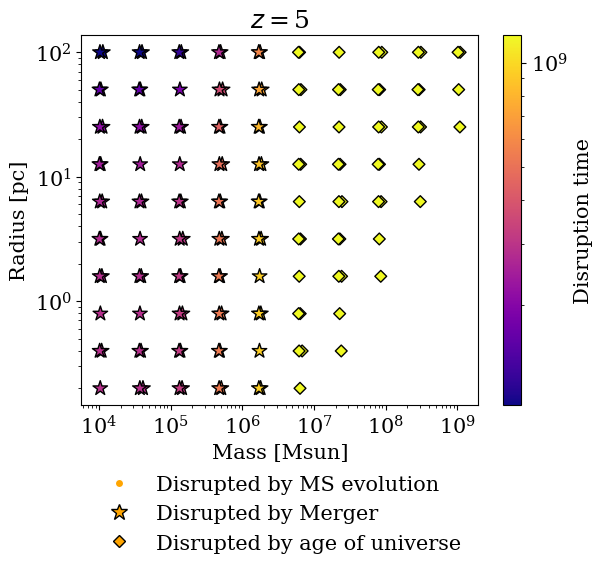

In [33]:
vratio = np.array([-results['potential'][i]/results['kinetic'][i] for i in range(len(results['potential']))])
x = np.array([results['mass'][i].value+(results['mass'][i].value *0.01 * vratio[i]) for i in range(len(vratio))]) * u.Msun
y = results['radius'] *u.pc
c = np.array(results['minimum_disruption_time']*u.yr)
mflag = np.array(results['which_disruption_time'])  # new flag array

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

# Mask zeros for log-scaling
c_masked = np.ma.masked_equal(c, 0)
norm = mcolors.LogNorm(vmin=c_masked.min(), vmax=c_masked.max())
cmap = plt.cm.plasma

# --- Separate the two populations by shape ---
mask_star = mflag == 0   # star markers
mask_circle = mflag == 1 # circle markers
mask_square= mflag == 2 # circle markers

# Plot circles (no mass loss)
sc1 = ax.scatter(x[mask_circle], y[mask_circle], 
                 c=np.ma.masked_equal(c[mask_circle], 0), 
                 cmap=cmap, norm=norm, marker='o')

# Plot stars (mass loss ≥1)
sc2 = ax.scatter(x[mask_star], y[mask_star], 
                 c=np.ma.masked_equal(c[mask_star], 0), 
                 cmap=cmap, norm=norm, marker='*', s=120, edgecolor='k')
# Plot stars (mass loss ≥1)
sc2 = ax.scatter(x[mask_square], y[mask_square], 
                 c=np.ma.masked_equal(c[mask_square], 0), 
                 cmap=cmap, norm=norm, marker='D',edgecolor='k')

# # Add explicit grey points for zeros
# ax.scatter(x[c == 0], y[c == 0], color="lightgrey", marker='o', alpha=0.7, label="0 collisions")

# --- Colorbar ---
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cb.set_label("Disruption time")

# Add legend for shapes
legend_handles = [
    # plt.Line2D([], [], marker='o', color='w', markerfacecolor='lightgrey',
    #            label='No collisions'),
    plt.Line2D([], [], marker='o', color='w', markerfacecolor='orange',
               label='Disrupted by MS evolution'),
    plt.Line2D([], [], marker='*', color='w', markerfacecolor='orange',
               markeredgecolor='k', markersize=12, label='Disrupted by Merger'),
    plt.Line2D([], [], marker='D', color='w', markerfacecolor='orange',
               markeredgecolor='k', label='Disrupted by age of universe')
]

ax.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.45),
    frameon=False
)
ax.set_xlabel("Mass [Msun]")
ax.set_ylabel("Radius [pc]")
plt.title(r"$z= $"+str(z_final))
plt.savefig("../plots/disruption_"+str(model.Mstar)+str(model.densityModel)+str(model.alpha)+str(model.imfModel)+"z"+str(z_final)+".pdf")
plt.show()